In [1]:
import jax.numpy as jnp
import jax.ops
import scipy as scipy
import scipy.integrate
import scipy.optimize
from jax import jit
from functools import partial
import numpy as np
from jax.experimental.ode import odeint
from ticktack import load_presaved_model, Box, Flow, CarbonBoxModel
import numpy as np
import matplotlib.pyplot as plt
from jax.lax import cond, dynamic_update_slice, fori_loop, dynamic_slice

In [12]:
@partial(jit, static_argnums=(0,2,3, 5, 6,7 ))
def run(cbm, time_out, oversample,production, y0=None, args=(), target_C_14=None, steady_state_production=None):
        @jit
        def derivative(y, t):
            ans = jnp.matmul(cbm._matrix, y)
            production_rate_constant = production(t, *args)
            production_rate_constant = cbm._convert_production_rate(production_rate_constant)
            production_term = cbm._production_coefficients * production_rate_constant
            return ans + production_term

        time_out = jnp.array(time_out)
        time_values = jnp.linspace(jnp.min(time_out) - 1, jnp.max(time_out) + 1, (time_out.shape[0] + 1) * oversample)
        solution = None
        if y0 is not None:
            y_initial = jnp.array(y0)
        else:
            if steady_state_production is not None:
                solution = cbm.equilibrate(production_rate=steady_state_production)

            elif target_C_14 is not None:
                solution = cbm.equilibrate(production_rate=cbm.equilibrate(target_C_14=target_C_14))
            else:
                ValueError("Must give either target C-14 or production rate.")
            y_initial = jnp.array(solution)

        if not callable(production):
            raise ValueError("incorrect object type for production")

        states = odeint(derivative, y_initial, time_values)
        return states, solution

In [13]:
@partial(jit, static_argnums=(0,2))
def bin_data(cbm, data, time_oversample, time_out, growth=jnp.ones((12,))):
    masked = jnp.linspace(0, 1, time_oversample)
    shifted_index = cond(growth[0] == 0, lambda x: 9, lambda x: 3, growth)
    shifted_index = cond(jnp.all(growth == 1), lambda x: 0, lambda x: shifted_index, growth)
    kernel = cond(shifted_index == 0, lambda x: x <= 1, lambda x: x < 0.5, masked)
    

        
    predict_batch_f = jax.vmap(partial(rebin1D, cbm, time_out, shifted_index, time_oversample, kernel),
                                   in_axes=1, out_axes=1)
    binned_data = predict_batch_f(data)
    return binned_data

@partial(jit, static_argnums=(0,3))
def rebin1D(cbm, time_out, shifted_index, oversample, kernel, s):
    binned_data = jnp.zeros((len(time_out), ))
    binned_data = fori_loop(0, len(time_out), lambda i, val: dynamic_update_slice(val, jnp.array([jnp.sum(jnp.multiply(dynamic_slice(
            s, ((i + 1) * oversample - shifted_index * oversample//12,), (oversample,)), kernel)) / (
                                                                              jnp.sum(kernel))]), (i,)), binned_data)

    return binned_data


In [6]:
def sg(t, start_time, duration, area):
    middle = start_time + duration / 2.
    height = area / duration
    return height * jnp.exp(- ((t - middle) / (1. / 1.88349 * duration)) ** 8.)


def miyake_event(t, start_time, duration, phase, area, steady_state_burn_in):
    height = sg(t, start_time, duration, area)
    prod = steady_state_burn_in + 0.18 * steady_state_burn_in * jnp.sin(2 * np.pi / 11 * t + phase) + height
    return prod

In [26]:
d_14_time_series_coarse = jnp.arange(760, 788)
old_burn_in = jnp.arange(760-1000, 759)
d_14_time_series_fine = jnp.linspace(759, 788, 29*1008)
burn_in_time = jnp.linspace(jnp.min(old_burn_in) - 1, jnp.max(old_burn_in) + 1, (old_burn_in.shape[0] + 1) * 108)

growth = jnp.array([1,1,1,1,1,1,1,1,1,1,1,1])



In [36]:
# working example
cbm = load_presaved_model('Guttler14', production_rate_units='atoms/cm^2/s')
cbm.compile()    
steady_state_burn_in = cbm.equilibrate(target_C_14=707)
burn_in_solutions1 = cbm.equilibrate(production_rate=steady_state_burn_in)
burn_in1, _ = run(cbm, old_burn_in, 108, production=miyake_event, args=(775, 1 / 12, np.pi / 2, 81 / 12, steady_state_burn_in),
                     y0=burn_in_solutions1)
event1, _ = run(cbm, d_14_time_series_coarse, 1008, production=miyake_event, args=(775, 1 / 12, np.pi / 2, 81 / 12, steady_state_burn_in),
                       y0=burn_in1[-1, :])

bin1 = bin_data(cbm, event1, 1008, d_14_time_series_coarse, growth= growth)

#d14c conversion
d14c_guttler = (bin1[:, 1] - burn_in_solutions1[1])/burn_in_solutions1[1]*1000


In [37]:
# not working example
cbm = load_presaved_model('Miyake17', production_rate_units='atoms/cm^2/s')
cbm.compile()   
burn_in_solutions4 = cbm.equilibrate(production_rate=1.8)
burn_in4, _ = run(cbm, old_burn_in, 108, production=miyake_event, args=(775, 1 / 12, np.pi / 2, 81/12, 1.8),
                     y0=burn_in_solutions4)


event4, _ = run(cbm, d_14_time_series_coarse, 1008, production=miyake_event, args=(775, 1/12, np.pi/2, 81/12, 1.8),
                       y0=burn_in4[-1, :])

# bins the above data
bin4 = bin_data(cbm, event4, 1008, d_14_time_series_coarse, growth= growth)

#d14c conversion
d14c_miyake = (bin4[:, 1] - burn_in_solutions4[1])/burn_in_solutions4[1]*1000



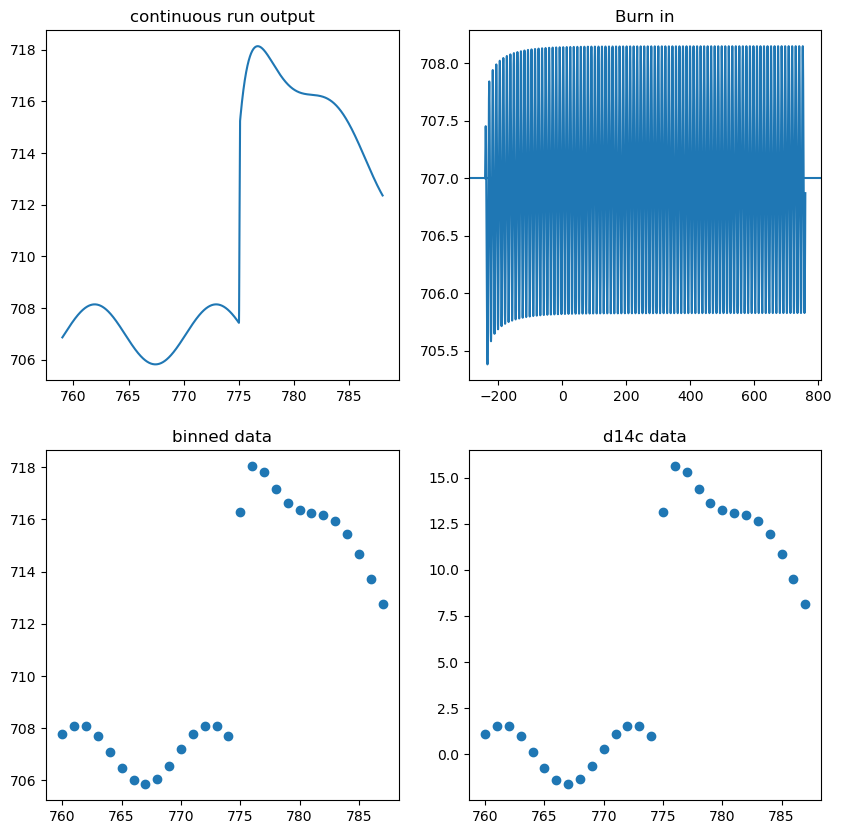

In [46]:
# working Guttler Example Graphs
# plotting continuous event
# index 1 in dimension 2 is the troposphere data

fig, axs = plt.subplots(2, 2,figsize=(10,10))
# plotting continuous event
# index 1 in dimension 2 is the troposphere data
axs[0,0].plot(d_14_time_series_fine, event1[:, 1])
axs[0,0].ticklabel_format(useOffset=False)
axs[0,0].set_title("continuous run output")

# # plotting burn in
axs[0,1].plot(time_values, burn_in1[:,1])
axs[0,1].axhline(burn_in_solutions1[1]) # steady state
axs[0,1].ticklabel_format(useOffset=False)
axs[0,1].set_title("Burn in")


# # plotting binned data 
axs[1,0].plot(d_14_time_series_coarse, bin1[:,1], 'o')
axs[1,0].ticklabel_format(useOffset=False)
axs[1,0].set_title("binned data")

# # plotting d14c
axs[1,1].plot(d_14_time_series_coarse, d14c_guttler, 'o')
axs[1,1].ticklabel_format(useOffset=False)
axs[1,1].set_title("d14c data")

plt.show()

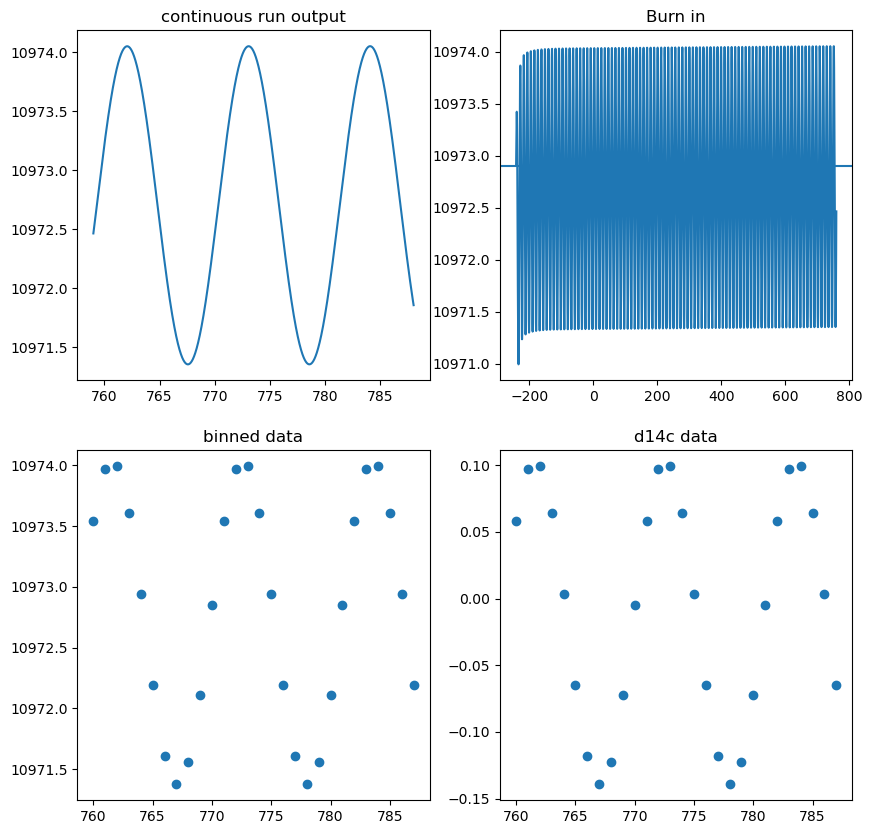

In [45]:
##### Not working Miyake Example ############

fig, axs = plt.subplots(2, 2,figsize=(10,10))
# plotting continuous event
# index 1 in dimension 2 is the troposphere data
axs[0,0].plot(d_14_time_series_fine, event4[:, 1])
axs[0,0].ticklabel_format(useOffset=False)
axs[0,0].set_title("continuous run output")

# # plotting burn in
axs[0,1].plot(time_values, burn_in4[:,1])
axs[0,1].axhline(burn_in_solutions4[1]) # steady state
axs[0,1].ticklabel_format(useOffset=False)
axs[0,1].set_title("Burn in")


# # plotting binned data 
axs[1,0].plot(d_14_time_series_coarse, bin4[:,1], 'o')
axs[1,0].ticklabel_format(useOffset=False)
axs[1,0].set_title("binned data")

# # plotting d14c
axs[1,1].plot(d_14_time_series_coarse, d14c_miyake, 'o')
axs[1,1].ticklabel_format(useOffset=False)
axs[1,1].set_title("d14c data")

plt.show()